In [5]:
# load dataset
import pandas as pd
X = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Projects/20200705_Bitcoin_LSTM/bitcoin_price.csv')
#make backup
K = X.copy()
K

,Unnamed: 0,timestamp,market-price
0,0,2015-07-08,265.83
1,1,2015-07-09,270.31
2,2,2015-07-10,269.00
3,3,2015-07-11,284.92
4,4,2015-07-12,291.64
...,...,...,...
1820,1820,2020-07-01,9133.97
1821,1821,2020-07-02,9236.38
1822,1822,2020-07-03,9087.98
1823,1823,2020-07-04,9072.42


In [7]:
from sklearn import preprocessing
import numpy as np

In [13]:
#convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True, drop_col=False, y_var=1):
  n_features = int(len(data.columns))
  n_vars = 1 if type(data) is list else data.shape[1]
  df = pd.DataFrame(data)
  cols, names = list(), list()
  # input sequence (t-n, ... t-1)
  for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
    names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
  # forecast sequence (t, t+1, ... t+n)
  for i in range(0, n_out):
    cols.append(df.shift(-i))
    if i == 0:
      names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    else:
      names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
  #put it all together
  agg = pd.concat(cols, axis=1)
  agg.columns = names
  # drop rows with NaN values
  if dropnan:
    agg.dropna(inplace=True)
    data = agg.copy()
    
  if drop_col == True:
    tot = n_features*n_in+n_features #24+8 = 32

    y_name = list(data.columns)[n_features*n_in-1 + y_var]
    y = data[y_name]
    for i in range(n_features*n_in, tot):
      data.drop(data.columns[[tot-n_features]], axis=1, inplace=True)
    data = pd.concat([data, y], axis=1)
  return data

In [19]:
def split(df, test_size):
  df = df.values
  len_df = df.shape[0]
  test_size = int(len_df*test_size)
  train, test = df[0:-test_size], df[-test_size:]
  return train, test

In [273]:
#original copy
X = K.copy()

#preprocessing
X.pop('Unnamed: 0')
index = X.pop('timestamp')
#scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
#X = pd.DataFrame(scaler.fit_transform(X))
X.index = index
X.columns = ['market-price']

X = series_to_supervised(X, 15, 1, drop_col=False)
X

#X, y
y = X.pop('var1(t)')

#scaling
scaler_ = preprocessing.MinMaxScaler(feature_range=(0, 1))
X = pd.DataFrame(scaler_.fit_transform(X))
X
scaler_ = preprocessing.MinMaxScaler(feature_range=(0, 1))
y = pd.DataFrame(scaler_.fit_transform(pd.DataFrame(y)))
y

#train, test
X_train_, X_test_ = split(X, 0.1)
y_train_, y_test_ = split(y, 0.1)
X_ = X.copy()
y_ = y.copy()
print(X_train_.shape, X_test_.shape, y_train_.shape, y_test_.shape)

(1629, 15) (181, 15) (1629, 1) (181, 1)


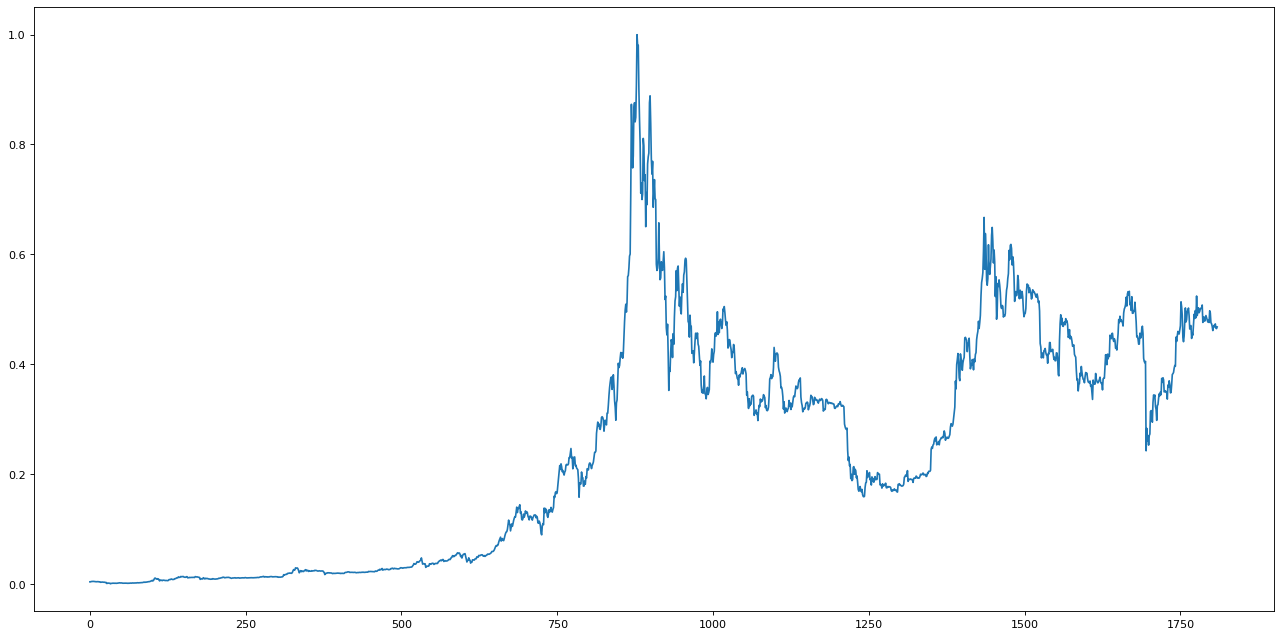

In [274]:
import matplotlib.pyplot as plt

fig=plt.figure(figsize=(20, 10), dpi= 80)
fig=plt.plot(y_)

In [275]:
def transform_to_stationary(df):
  #create a differenced series
  def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
      value = dataset[i] - dataset[i - interval]
      diff.append(value)
    return pd.DataFrame(diff)
  
  df = df.values #al di fuori delle funzioni voglio operare solo su un DataFrame
  df = difference(df, 1) #X ritorna ad essere un df
  return df

In [276]:
#only scaling
X = K.copy()

#preprocessing
X.pop('Unnamed: 0')
index = X.pop('timestamp')
#scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
#X = pd.DataFrame(scaler.fit_transform(X))
X.index = index

X.columns = ['market-price']

X = transform_to_stationary(X)

X = series_to_supervised(X, 15, 1, drop_col=False)
X

#X, y
y = X.pop('var1(t)')

#scaling
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
X = pd.DataFrame(scaler.fit_transform(X))
X
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
y = pd.DataFrame(scaler.fit_transform(pd.DataFrame(y)))
y

#train, test
X_train, X_test = split(X, 0.1)
y_train, y_test = split(y, 0.1)
X = X.copy()
y = y.copy()
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1629, 15) (180, 15) (1629, 1) (180, 1)


In [ ]:
#original values
y_test_

In [ ]:
#gaps among values (be careful, with a different scaler)
y_test

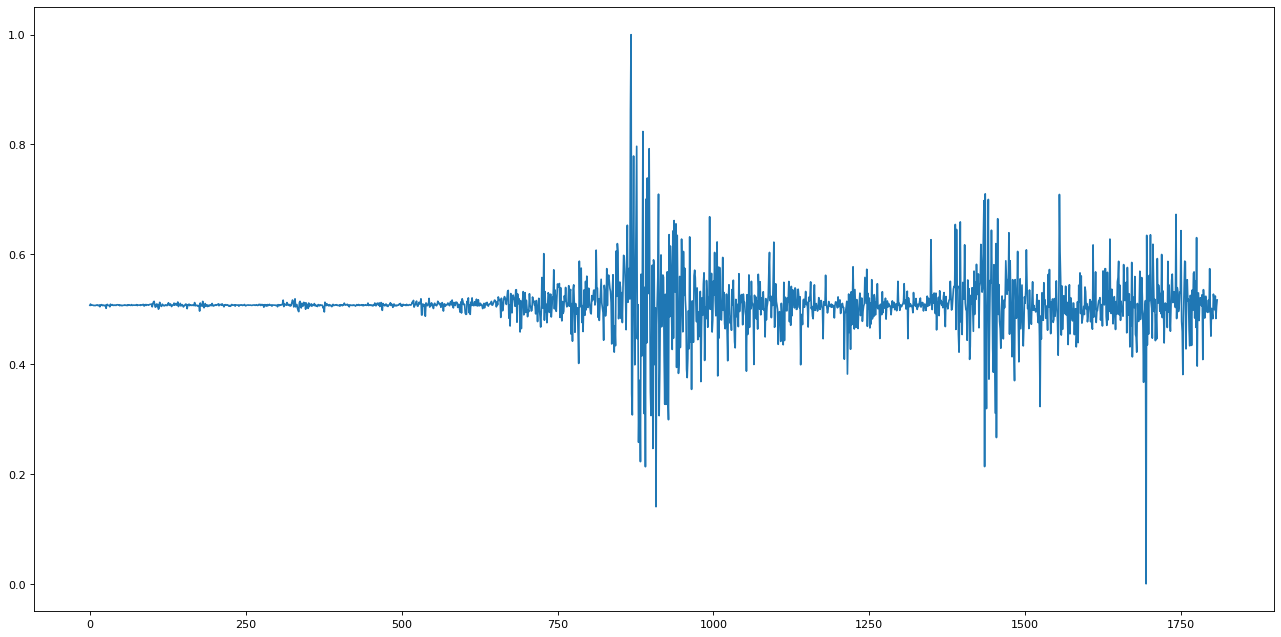

In [279]:
import matplotlib.pyplot as plt

fig=plt.figure(figsize=(20, 10), dpi= 80)
fig=plt.plot(y)

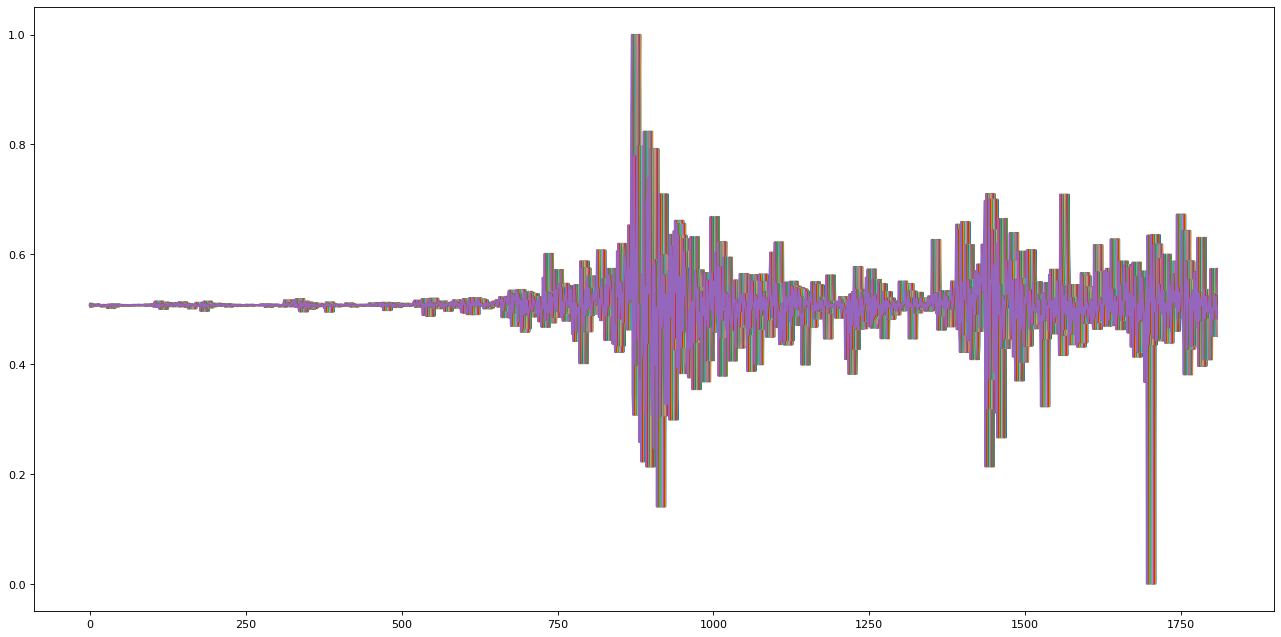

In [280]:
import matplotlib.pyplot as plt

fig=plt.figure(figsize=(20, 10), dpi= 80)
fig=plt.plot(X)

In [282]:
#(1629, 15) (180, 15) (1629,) (180,)
#reshape [samples, n_input_timesteps, n_features]
X_train = X_train.reshape((1629, 15, 1))
y_train = y_train.reshape((1629, 1, 1))
print(X_train.shape, y_train.shape)
#every sample has dimensions [1, 3, 1]

(1629, 15, 1) (1629, 1, 1)


In [247]:
#senza stationary nè scaling: y_test_ = y_test

##Building the Model

In [283]:
#LSTM
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

model = Sequential()
model.add(LSTM(50, batch_input_shape=(1, 15, 1), stateful=True)) #dimensions of every single sample
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

model.fit(X_train, y_train, epochs=30, batch_size=1, verbose=2, shuffle=False)
model.reset_states()

X_test = X_test.reshape(180, 15, 1)
y_test = y_test.reshape(180, 1, 1)
print(X_test.shape, y_test.shape)

Epoch 1/30
1629/1629 - 7s - loss: 0.0037
Epoch 2/30
1629/1629 - 7s - loss: 0.0027
Epoch 3/30
1629/1629 - 7s - loss: 0.0027
Epoch 4/30
1629/1629 - 7s - loss: 0.0026
Epoch 5/30
1629/1629 - 7s - loss: 0.0026
Epoch 6/30
1629/1629 - 7s - loss: 0.0026
Epoch 7/30
1629/1629 - 7s - loss: 0.0026
Epoch 8/30
1629/1629 - 7s - loss: 0.0025
Epoch 9/30
1629/1629 - 7s - loss: 0.0025
Epoch 10/30
1629/1629 - 7s - loss: 0.0025
Epoch 11/30
1629/1629 - 7s - loss: 0.0025
Epoch 12/30
1629/1629 - 7s - loss: 0.0025
Epoch 13/30
1629/1629 - 7s - loss: 0.0025
Epoch 14/30
1629/1629 - 7s - loss: 0.0025
Epoch 15/30
1629/1629 - 7s - loss: 0.0025
Epoch 16/30
1629/1629 - 7s - loss: 0.0025
Epoch 17/30
1629/1629 - 7s - loss: 0.0025
Epoch 18/30
1629/1629 - 7s - loss: 0.0025
Epoch 19/30
1629/1629 - 7s - loss: 0.0025
Epoch 20/30
1629/1629 - 7s - loss: 0.0025
Epoch 21/30
1629/1629 - 7s - loss: 0.0025
Epoch 22/30
1629/1629 - 7s - loss: 0.0025
Epoch 23/30
1629/1629 - 7s - loss: 0.0025
Epoch 24/30
1629/1629 - 7s - loss: 0.0025
E

In [284]:
#make a one-step forecast
yhat = model.predict(X_test, verbose=2, batch_size=1)
#without batch_size the model only accepts one input at a time
yhat

180/180 - 0s


array([[0.507557  ],
       [0.5075614 ],
       [0.5051364 ],
       [0.5072254 ],
       [0.50906575],
       [0.5039239 ],
       [0.5100969 ],
       [0.50429094],
       [0.5126817 ],
       [0.5014569 ],
       [0.5101533 ],
       [0.5059304 ],
       [0.5072363 ],
       [0.50566983],
       [0.50782   ],
       [0.50710416],
       [0.5064651 ],
       [0.50617445],
       [0.5083985 ],
       [0.5056317 ],
       [0.5096288 ],
       [0.5064622 ],
       [0.5093268 ],
       [0.50396955],
       [0.51033604],
       [0.5033924 ],
       [0.50980735],
       [0.5046662 ],
       [0.50844496],
       [0.5055037 ],
       [0.51060414],
       [0.504429  ],
       [0.50872576],
       [0.5062976 ],
       [0.50851727],
       [0.50385314],
       [0.5118074 ],
       [0.5032834 ],
       [0.50864965],
       [0.5067729 ],
       [0.5044164 ],
       [0.50974345],
       [0.5039733 ],
       [0.5120342 ],
       [0.4999443 ],
       [0.51287663],
       [0.5037787 ],
       [0.508

##Invert Preprocessing on Output

In [285]:
#inverse scaling of the prediction
raw = scaler_.inverse_transform(yhat)
raw

array([[ 9889.534 ],
       [ 9889.618 ],
       [ 9843.376 ],
       [ 9883.211 ],
       [ 9918.305 ],
       [ 9820.255 ],
       [ 9937.968 ],
       [ 9827.254 ],
       [ 9987.258 ],
       [ 9773.212 ],
       [ 9939.043 ],
       [ 9858.518 ],
       [ 9883.419 ],
       [ 9853.548 ],
       [ 9894.55  ],
       [ 9880.899 ],
       [ 9868.713 ],
       [ 9863.171 ],
       [ 9905.58  ],
       [ 9852.82  ],
       [ 9929.041 ],
       [ 9868.658 ],
       [ 9923.283 ],
       [ 9821.126 ],
       [ 9942.527 ],
       [ 9810.12  ],
       [ 9932.446 ],
       [ 9834.41  ],
       [ 9906.467 ],
       [ 9850.381 ],
       [ 9947.641 ],
       [ 9829.887 ],
       [ 9911.821 ],
       [ 9865.519 ],
       [ 9907.846 ],
       [ 9818.906 ],
       [ 9970.585 ],
       [ 9808.041 ],
       [ 9910.37  ],
       [ 9874.582 ],
       [ 9829.646 ],
       [ 9931.228 ],
       [ 9821.197 ],
       [ 9974.909 ],
       [ 9744.368 ],
       [ 9990.974 ],
       [ 9817.486 ],
       [ 9916

In [286]:
#inverse scaling of the gaps
#non so perchè prima ho fatto un reshaping, sembra senza ragione
#comunque, ora correggo
y_test = y_test.reshape(180, 1)
gap = scaler.inverse_transform(y_test)
gap

array([[ 4.06230e+02],
       [-1.22820e+02],
       [-2.24730e+02],
       [ 3.66740e+02],
       [-1.63170e+02],
       [ 1.52480e+02],
       [-6.87300e+01],
       [ 7.37180e+02],
       [-2.85300e+01],
       [-9.18600e+01],
       [ 1.78310e+02],
       [ 1.05100e+01],
       [-2.07490e+02],
       [-7.68900e+01],
       [ 9.57900e+01],
       [-6.33200e+01],
       [-2.70830e+02],
       [ 4.00600e+01],
       [-1.00810e+02],
       [ 2.61060e+02],
       [ 3.07360e+02],
       [ 4.89910e+02],
       [-1.05880e+02],
       [ 2.22560e+02],
       [-1.68600e+02],
       [ 4.43200e+01],
       [-6.35300e+01],
       [-3.00500e+01],
       [-1.22370e+02],
       [ 4.52760e+02],
       [ 1.40760e+02],
       [ 5.18800e+01],
       [ 9.95800e+01],
       [ 2.55290e+02],
       [-3.07620e+02],
       [ 4.20590e+02],
       [ 7.89200e+01],
       [-1.11870e+02],
       [ 1.26100e+02],
       [-4.64360e+02],
       [ 3.35000e+01],
       [-2.33740e+02],
       [ 4.76720e+02],
       [-5.

In [287]:
#   invert preprocessing on predicted data
#remove stationary
y_test = y_test.reshape(180, 1)
var1 = raw    #original values
var2 = gap     #gaps
var3 = list()     #

#var1 = var1.values
#var2 = var2.values

var3.append(var1[0])
for i in range(0, len(var2)-1):
  values = var1[i] + var2[i+1]
  print('values: ', var1[i], var2[i+1])
  var3.append(values)
var3

values:  [9889.534] [-122.82]
values:  [9889.618] [-224.73]
values:  [9843.376] [366.74]
values:  [9883.211] [-163.17]
values:  [9918.305] [152.48]
values:  [9820.255] [-68.73]
values:  [9937.968] [737.18]
values:  [9827.254] [-28.53]
values:  [9987.258] [-91.86]
values:  [9773.212] [178.31]
values:  [9939.043] [10.51]
values:  [9858.518] [-207.49]
values:  [9883.419] [-76.89]
values:  [9853.548] [95.79]
values:  [9894.55] [-63.32]
values:  [9880.899] [-270.83]
values:  [9868.713] [40.06]
values:  [9863.171] [-100.81]
values:  [9905.58] [261.06]
values:  [9852.82] [307.36]
values:  [9929.041] [489.91]
values:  [9868.658] [-105.88]
values:  [9923.283] [222.56]
values:  [9821.126] [-168.6]
values:  [9942.527] [44.32]
values:  [9810.12] [-63.53]
values:  [9932.446] [-30.05]
values:  [9834.41] [-122.37]
values:  [9906.467] [452.76]
values:  [9850.381] [140.76]
values:  [9947.641] [51.88]
values:  [9829.887] [99.58]
values:  [9911.821] [255.29]
values:  [9865.519] [-307.62]
values:  [9907.8

[array([9889.534], dtype=float32),
 array([9766.71417969]),
 array([9664.88816406]),
 array([10210.11597656]),
 array([9720.0409375]),
 array([10070.7846875]),
 array([9751.52488281]),
 array([10675.14777344]),
 array([9798.72390625]),
 array([9895.3978125]),
 array([9951.52191406]),
 array([9949.55296875]),
 array([9651.02757813]),
 array([9806.52894531]),
 array([9949.33785156]),
 array([9831.22980469]),
 array([9610.06941406]),
 array([9908.77289062]),
 array([9762.36089844]),
 array([10166.64007812]),
 array([10160.1803125]),
 array([10418.95101562]),
 array([9762.77820312]),
 array([10145.84320313]),
 array([9652.52597656]),
 array([9986.84734375]),
 array([9746.59011719]),
 array([9902.39628906]),
 array([9712.04015625]),
 array([10359.22679688]),
 array([9991.14085938]),
 array([9999.520625]),
 array([9929.46671875]),
 array([10167.11128906]),
 array([9557.89855469]),
 array([10328.43570312]),
 array([9897.82625]),
 array([9858.71496094]),
 array([9934.14101563]),
 array([9446.0

In [288]:
predicted = var3

In [289]:
#invert preprocessing on expected data
#inverse scaling
expected = scaler_.inverse_transform(y_test_)
expected

array([[ 7759.24],
       [ 8165.47],
       [ 8042.65],
       [ 7817.92],
       [ 8184.66],
       [ 8021.49],
       [ 8173.97],
       [ 8105.24],
       [ 8842.42],
       [ 8813.89],
       [ 8722.03],
       [ 8900.34],
       [ 8910.85],
       [ 8703.36],
       [ 8626.47],
       [ 8722.26],
       [ 8658.94],
       [ 8388.11],
       [ 8428.17],
       [ 8327.36],
       [ 8588.42],
       [ 8895.78],
       [ 9385.69],
       [ 9279.81],
       [ 9502.37],
       [ 9333.77],
       [ 9378.09],
       [ 9314.56],
       [ 9284.51],
       [ 9162.14],
       [ 9614.9 ],
       [ 9755.66],
       [ 9807.54],
       [ 9907.12],
       [10162.41],
       [ 9854.79],
       [10275.38],
       [10354.3 ],
       [10242.43],
       [10368.53],
       [ 9904.17],
       [ 9937.67],
       [ 9703.93],
       [10180.65],
       [ 9604.72],
       [ 9606.86],
       [ 9696.58],
       [ 9669.63],
       [ 9989.39],
       [ 9663.75],
       [ 9309.15],
       [ 8785.52],
       [ 880

In [292]:
for i in range(len(y_test_)-1):
  print('iteration=%d, Predicted=%f, Expected=%f' % (i+1, predicted[i], expected[i]))

iteration=1, Predicted=9889.534180, Expected=7759.240000
iteration=2, Predicted=9766.714180, Expected=8165.470000
iteration=3, Predicted=9664.888164, Expected=8042.650000
iteration=4, Predicted=10210.115977, Expected=7817.920000
iteration=5, Predicted=9720.040937, Expected=8184.660000
iteration=6, Predicted=10070.784688, Expected=8021.490000
iteration=7, Predicted=9751.524883, Expected=8173.970000
iteration=8, Predicted=10675.147773, Expected=8105.240000
iteration=9, Predicted=9798.723906, Expected=8842.420000
iteration=10, Predicted=9895.397813, Expected=8813.890000
iteration=11, Predicted=9951.521914, Expected=8722.030000
iteration=12, Predicted=9949.552969, Expected=8900.340000
iteration=13, Predicted=9651.027578, Expected=8910.850000
iteration=14, Predicted=9806.528945, Expected=8703.360000
iteration=15, Predicted=9949.337852, Expected=8626.470000
iteration=16, Predicted=9831.229805, Expected=8722.260000
iteration=17, Predicted=9610.069414, Expected=8658.940000
iteration=18, Predic

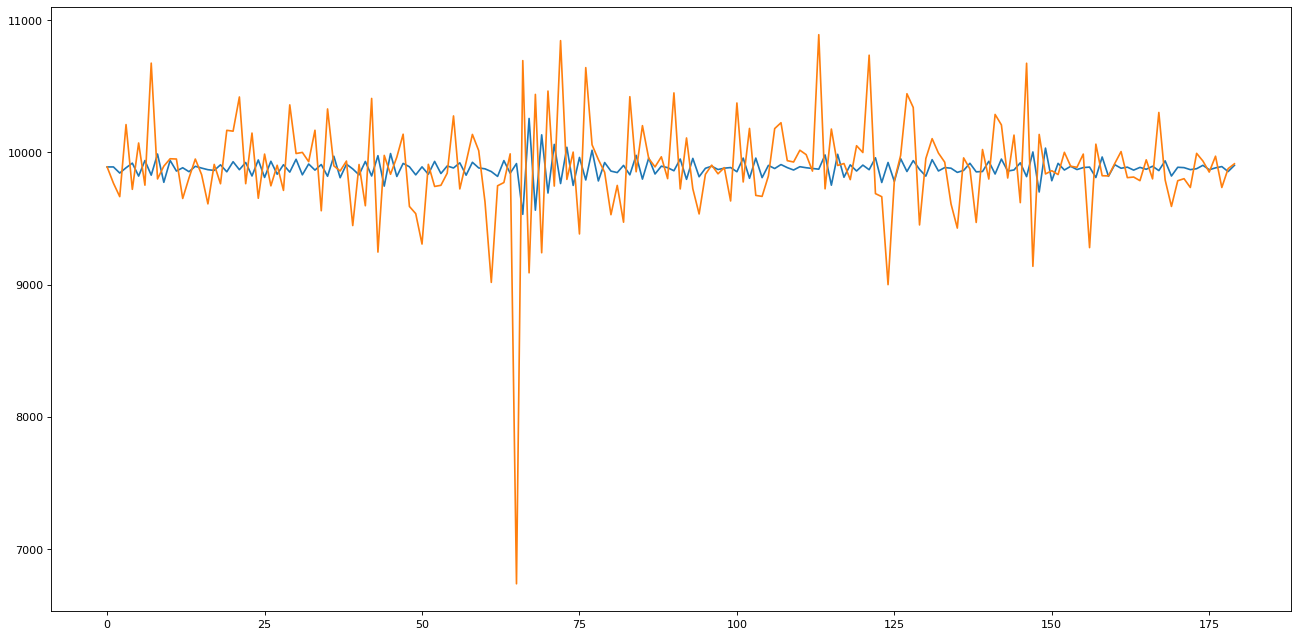

In [293]:
import matplotlib.pyplot as plt

fig=plt.figure(figsize=(20, 10), dpi= 80)
fig=plt.plot(raw)
fig=plt.plot(predicted)

In [259]:
# report performance
from math import *
from sklearn.metrics import mean_squared_error
rmse = sqrt(mean_squared_error(raw, predicted))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted

Test RMSE: 151.512
